In [4]:
#%%
#            Chem 210A  Prof. McCurdy  2021
#
"""  Template for calculating a potential curve for a diatomic or one degree of freedom 
      for a polyatomic molecule

        using psi4 as a python module
  
    Starting point for Chem 210A problems -- CWM January 29, 2021

    This example does Hartree-Fock on H2,
    
    Minor changes allow MP2 and CISD calculations on this and other diatomics
    To do DFT, use b3lyp, for example -- see Psi4 manual
    With suitable modifications in the geometry specification 
    this template can be used to calculate a bond 
    stretching curve for a polyatomic
"""    

'  Template for calculating a potential curve for a diatomic or one degree of freedom \n      for a polyatomic molecule\n\n        using psi4 as a python module\n  \n    Starting point for Chem 210A problems -- CWM January 29, 2021\n\n    This example does Hartree-Fock on H2,\n    \n    Minor changes allow MP2 and CISD calculations on this and other diatomics\n    To do DFT, use b3lyp, for example -- see Psi4 manual\n    With suitable modifications in the geometry specification \n    this template can be used to calculate a bond \n    stretching curve for a polyatomic\n'

In [5]:
#    this is the  H2_scf_andDFT file
#    the output is just  Calculated_Energies
    
    
    
    
#%%
#                    IMPORT MODULES
#
import psi4  #  import all of psi4
#  regular expression library is used for replacing strings with numbers in geometry specification
import re as re  # regular expression library 
# numpy library is used for all numerical calculations in python that we program specifically here 
import numpy as np # numpy library for numerical calculations
import os     # operating system commands for manipulating files
import matplotlib.pyplot as plt   
from datascience import*
%matplotlib inline 
plt.style.use('fast')

#                 SET MEMORY
#
psi4.set_memory('2048 MB')     # minimum memory should be 1 GB, 2GB or greater is better
#
#
#        SET FILE NAMES FOR OUTPUT FILES 
#         change names between runs to save them
#
#  File for output from Psi4 is a  .txt file 
file_string_output = 'output_potential_curve.txt'  # output file
#  molden output must be a .molden file
molden_file_name = "diatomic_scf.molden"   # molden file 
#  File for plotting potential curve 
plot_file_name = 'potcurve.dat'      # plotting file
#
# remove these files, especially the molden file if it exists
# to prevent psi4 from appending to existing file
if os.path.exists(molden_file_name):
  os.remove(molden_file_name)
if os.path.exists(plot_file_name):
  os.remove(plot_file_name)
if os.path.exists(file_string_output):
  os.remove(file_string_output)
psi4.core.set_output_file(file_string_output,False) 
print("psi4 output is directed to ",file_string_output,"\n")
#%%
#

#                    SPECIFY GEOMETRY PYTHON OBJECT
#
# R_value  =  the internuclear distance in a0
# and must be replaced by a number using the regular expression functions
# in the for loop on distances.
#
# Specifying cartesian coordinates in this example
# Types of atoms are specified by chemical symbol
# First line is charge and spin multiplicity 
# 0 1 => neutral  singlet 
# 0 3 => neutral triplet and requires ROHF ('rohf' reference for 'scf' below)
# c1 = C_1 symmetry (no symmetry) OK for RHF (and necessary for unrestricted Hartree-Fock (UHF))
# d2h => is fastest for homonuclear diatomics.  Irreps are (in this order in some commands for open shell systems)
#   Ag   B1g   B2g   B3g    Au   B1u   B2u   B3u 
# c2v => is fastest for heteronuclear diatomics.  Irreps are (in this order in some commands for open shell systems)#
#   A1    A2    B1    B2 
#

molecular_geometry  =  """
      0 1 
      H  0.0 0.0 0.0 
      H  0.0 0.0 R_value 

    units bohr
    symmetry c2v """

#   print the geometry template
print(molecular_geometry)
#

psi4 output is directed to  output_potential_curve.txt 


      0 1 
      H  0.0 0.0 0.0 
      H  0.0 0.0 R_value 

    units bohr
    symmetry c2v 


In [6]:
#  psi4 options that do not change with R value
# 
#                               BASIS SET
#  cc-pVDZ is a small correlation consistent Dunning basis - good for first calculation.
#  (Sometimes won't be  good enough for Chem 210A final answers
#  see Psi4 manual for many other built-in basis sets
#
psi4.set_options({'basis': 'cc-pvDZ'}) 
#
#                        METHOD (OR REFERENCE METHOD for MP2, CISD or CCSD)
#   Method, and/or  reference for CI or MP2 calculations is set here
# "rhf" for restricted HF for closed shells, 
# "rohf" for restricted open-shell HF for open shells, like triplets, requires other options to be set 
#     also necessary for the CI code DetCI in Psi4.  cisd requires rohf reference
psi4.set_options({"reference": "rhf"})  
#  scf_type is a keyword that controls the algorithm for handling the four-index electron repulsion integrals.  
# 'pk' is a safe out-of-core algorithm using exact electron repulsion integrals.  
psi4.set_options({'scf_type': 'pk'}) 
# 'df' denotes a density-fitted algorithm designed for computations with thousands of basis functions. 
#  It is required for MP2 (Moller-Plesset 2nd order perturbation theory)
#psi4.set_options({'scf_type': 'df'}) 
#

#                          SCF INITIAL GUESS
#  Initial guess options for SCF, very important for UHF and sometimes ROHF or RHF
#  RHF is usually not difficult to converge.
#
#psi4.set_options({'guess': 'read'})  #  can be used to follow a solution for difficult cases as R changes
#                                 #  if we run an initial point before the loop on R with another option
#                                 #  then set guess: 'read' before starting the loop which is used for subsequent points
#   guess: 'core' good for closed shell restricted Hartree-Fock 
psi4.set_options({'guess': 'core'})    # diagonalize core (nuclear attraction only) Hamiltonian for guess
#
#  some other guess options that help converge rohf and some rhf  calculations 
#psi4.set_options({'guess': 'sad'})    # superposition of atomic densities (SAD) guess
#psi4.set_options({'guess': 'gwh'})    # generalized Wolfsberg-Helmholz Huckel-like guess
psi4.set_options({"MAXITER": 500})    # If near 500 iterations are necessary, calculation is on the edge of failure
#%%
# 

#               SINGLE POINT CALCULATION 
#      uncomment to do single point calculations 
#
#R = 1.4
#molecular_geometry_R = re.sub("R_value",str(R),molecular_geometry)
#scf_energy, wfcn = psi4.energy('scf',molecule=psi4.geometry(molecular_geometry_R),return_wfn=True)
#print("\n Single point calculation at R = ",R,"   psi4 scf energy = ", scf_energy)
#print(" Writing molden file ",molden_file_name)
#psi4.molden(wfcn,molden_file_name)
#exit()
#%%
#

#                    POTENTIAL CURVE CALCULATION
#
#  parameters for the curve
#
N_Rvals = 91  # when debugging use a small number of R values
Rmin = 0.8    # use a larger or smaller Rmin for some molecules (using bohr here) 
Rmax = 10.0
dr = (Rmax-Rmin)/(N_Rvals-1)
#
#  arrays for the R values and energies
#
Rvals=[]
Calculated_Energies=[]
#
#%%
#
# LOOP over R values 
#
print("\n ** Beginning potential curve calculation ** \n")
for n in range(N_Rvals):
    R = Rmin + n*dr
#

# The following command substitutes a string made from the value of the
# variable R for the the string "R_value" in the python object molecular_geometry
# to make a new object molecular_geometry_R .  It can be applied several times
# in succession, renaming the result each time, to replace several 
# strings to create a new geometry object
#
    molecular_geometry_R = re.sub("R_value",str(R),molecular_geometry)
#
#    print(molecular_geometry_R)  # print current geometry -- uncomment for debugging
#
#  generally safest to use guess = read after the first point to follow solution for a potential curve
    if (n !=  0):
        psi4.set_options({'guess': 'read'})  #  can be used to follow a solution for difficult cases as R changes
#
#  method is specified here 'scf' assumes a reference to have been set
#  rhf,  rohf or uhf for example
#  'mp2'  also requires a reference (like rhf or rohf) as does 'cisd'
#
#               SCF calculation at this R point 
#    scf_energy=psi4.energy('b3lyp',molecule=psi4.geometry(molecular_geometry_R) ) # DFT specify functional
#    scf_energy=psi4.energy('mp2',molecule=psi4.geometry(molecular_geometry_R) )   # MP2 see requirements above
    scf_energy=psi4.energy('scf',molecule=psi4.geometry(molecular_geometry_R) )
    print("R = ",R," scf energy =  ", scf_energy)
    Rvals.append(R)
    Calculated_Energies.append(scf_energy)
#
#  for loop ends here
##

#%%
#                   MAKE OUTPUT FILE FOR PLOTTING
#  at the end of the for loop both print and make a file
#  containing the scf energies
#
f = open(plot_file_name,'w')  # optionally rename this file for the case at hand
print("\n Making plot file named ",plot_file_name)
for n in range(N_Rvals):
    print(Rvals[n],"   ",Calculated_Energies[n],file=f)
#   print(Rvals[n],"   ",Calculated_Energies[n]) # echo plotting output to console
#


 ** Beginning potential curve calculation ** 

R =  0.8  scf energy =   -0.9559700344744684
R =  0.9022222222222223  scf energy =   -1.027172128026936
R =  1.0044444444444445  scf energy =   -1.0729401398519585
R =  1.1066666666666667  scf energy =   -1.1014811504924515
R =  1.208888888888889  scf energy =   -1.1181142267124038
R =  1.3111111111111111  scf energy =   -1.1263925032692046
R =  1.4133333333333333  scf energy =   -1.1287461141253952
R =  1.5155555555555555  scf energy =   -1.1268715195241437
R =  1.6177777777777778  scf energy =   -1.1219759356763603
R =  1.72  scf energy =   -1.1149335226245385
R =  1.8222222222222222  scf energy =   -1.1063862621393872
R =  1.9244444444444444  scf energy =   -1.0968101265871262
R =  2.0266666666666664  scf energy =   -1.0865596319900925
R =  2.1288888888888886  scf energy =   -1.075898924006409
R =  2.231111111111111  scf energy =   -1.0650242965937438
R =  2.333333333333333  scf energy =   -1.0540810059829626
R =  2.4355555555555553  s

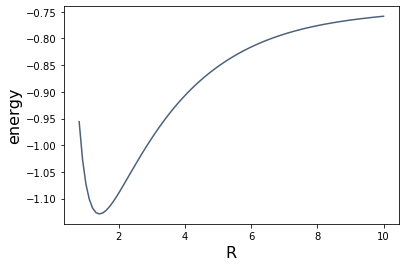

In [7]:
one_u_one_g= Table().with_columns("R",Rvals,"energy",Calculated_Energies)
pne_u_one_g.plot(0)

In [8]:
#%% This is the H2_cisd file 
#   The output is the Calculated_Energies1






#            Chem 210A (and Chem 2A figures) 2021  Prof. McCurdy
#
"""  Template for calculating a potential curve 
        using psi4 as a python module
  
    This began from a starting point for Chem 210A problems -- CWM November 1, 2017

    CISD on H2.  Getting N_roots eigenvalues from the CI is implemented here for an,
                 in principle, arbitrary number of roots

      
"""

#%%
#                    IMPORT MODULES
#
import psi4  #  import all of psi4
import re as re   #  regular expression library 
import numpy as np # numpy library for square roots etc.in gemometry and unit manipulations
# will work with small memory (512 MB, fopr example) for small cases but for CI larger memory
# is necessary for others
import matplotlib.pyplot as plt
psi4.set_memory('5120  MB')           # minimum memory should be 1 GB, 2GB or greater is better
#
filestring = 'output_H2_singlets_CISD.txt'          # file for complete output -- change name to save it 
psi4.core.set_output_file(filestring,False) # from being written over when doing another case
print("psi4 output is directed to ",filestring,"\n")
#

#%%
#                    SPECIFY GEOMETRY PYTHON OBJECT
#
# R_value  =  the internuclear distance in a0
# and must be replaced by a number using the regular expression functions
# in the loop on distances.
#
# NOTE if we want to  use UHF guess_mix true option, we must use c1 symmetry
# (no symmetry) just as we must when doing geometry optimizations 
# For CISD c1 symmetry allow us to get singlet Sigma_g, Sigma_u, Pi_g, Pi_u
# etc. from a single CI calculation
#
# Specifying cartesian coordinates in this example, type of atom
# and its charge are specified by the chemical symbol
# first line is charge and spin multiplicity 1 = singlet 
# 3 = triplet and requires ROHF ('rohf' reference for 'scf' below)
# c1 = C_1 symmetry (no symmetry) OK for RHF and necessary for UHF

H2_geometry  =  """
      0 1 
      H  0.0 0.0 0.0 
      H  0.0 0.0 R_value 
    units bohr
    symmetry c1 """

#   print the geometry 
print(H2_geometry)

#
#  parameters for the curve
#
N_Rvals1 = 91  # when debugging use a small number of R values
Rmin1 = 0.8    # Minimum for H2 is near 1.4 bohr
Rmax1 = 10.0
dr1 = (Rmax1-Rmin1)/(N_Rvals1-1)
#
#  psi4 options that do not change with R value
# 
#                               BASIS SET
#  cc-pVDZ is a small correlation consistent Dunning basis - good for first calculation.
#  (Sometimes won't be  good enough for Chem 210A final answers
#  but for UHF larger basis sets sometimes harder to converge to 
#  spin symmetry broken result. Options given here work for double zeta and 
#  triple zeta correlation consistent basis sets for H2)
#
psi4.set_options({'basis': 'cc-pvDZ'}) # augmented basis to describe lowest Rydberg states
#psi4.set_options({'basis': 'cc-pvTZ'}) 
#
#                        METHOD OR REFERENCE METHOD 
#   Method, and/or  reference for CI or MP2 calculations is set here
psi4.set_options({'reference': 'rohf'}) #DETCI seems to need rohf even if reference is equivalent to rhf 
#
#                          SCF INITIAL GUESS
#  initial guess options for SCF, very important for UHF and sometimes ROHF
psi4.set_options({'guess':'core'}) # diagonalize core hamiltonian (nuclear attraction only)
#psi4.set_options({'guess': 'read'})  #  can be used to follow a solution as R changes
#  if we run an initial point before the loop on R or after the first point
#

#
Rvals1=[]
Calculated_Energies1=[]
#
#%%
# LOOP over R values 
#
for n in range(N_Rvals1):
    R = Rmin1 + n*dr1
#
# The following command substitutes a string made from the value of the
# variable R for the the string "R_value" in the python object H2_geometry
# to make a new object H2_geometry_R .  It can be applied several times
# in succession, renaming the result each time, to replace several 
# strings to create a new geometry object
#
    H2_geometry_R = re.sub("R_value",str(R),H2_geometry)
#
#    print(H2_geometry_R)  # print current geometry -- uncomment for debugging
#
    if (n != 0):
      psi4.set_options({'guess': 'read'})  #  can be used to follow a solution as R changes
      #  if we run an initial point before the loop on R or after the first point
#
# set reference for CI
#    psi4.set_options({'SOCC':[2]}) # scf reference for triplet H2, for example 
#    psi4.set_options({'DOCC':[0]}) # 
    psi4.set_options({'SOCC':[0]}) #scf reference for singlet H2, for example 
    psi4.set_options({'DOCC':[1]}) #
#    freeze_array=[0]  # for freezing core orbitals in CISD in larger cases
#    psi4.set_options({'FROZEN_DOCC': freeze_array})
#
#  set number of CI roots here
    N_roots =  1 
#  For H2 singlets, the first three are the X Sigma_g^+, B Sigma_u^+ and E,F Sigma_g^+ 
    psi4.set_options({'NUM_ROOTS': N_roots})     
    psi4.set_options({'CI_MAXITER': 100})     
    psi4.set_options({'DIAG_METHOD':'DAVIDSON'}) # a little faster sometimes than default SEM
#
    finalenergy=psi4.energy('cisd',molecule=psi4.geometry(H2_geometry_R) )

#    finalenergy, wfcninitial  =psi4.energy('scf',molecule=NH3,return_wfn=True)
    print("R  = ",R,"   psi4.energy (CISD) singlet A  ", finalenergy)
    scf_energy = psi4.core.get_variable('SCF TOTAL ENERGY')
    print("scf energy = ",scf_energy)
    print("R = ",R,"   psi4.energy   ", finalenergy)
#

# This is how to get different CI root energies into python
# coded here with string construction to allow calculating N_roots eigenvalues
# 
    energyroots1 = []
    for iroot in range(N_roots):
       energyrootTemp  = psi4.core.get_variable('CI ROOT '+str(iroot)+' TOTAL ENERGY')
       energyroots1.append(energyrootTemp)
    print("CI energies for roots  = ",energyroots1)
#
    Rvals1.append(R)
    Calculated_Energies1.append(energyroots1)
#

#%%
#                   MAKE OUTPUT FILE FOR PLOTTING
#  at the end of the for loop both print and make a file
#  containing the scf energies
#

# reduced mass for ^4He_2
# = Mass of ^4He in u times mass of electron in u /2
mu  = (4.0015061791*1822.888486)/2.0
f = open('potcurve_H2_singlets.dat','w')  # rename this file for the case at hand
HatomEnergy = 0.0 # no shift of zero of energy to compare with other methods directly
#HatomEnergy = -0.5   # set a zero of energy for separated atoms for  potential curves
for n in range(N_Rvals):
    for istate in range(N_roots):
       Calculated_Energies1[n][istate] = Calculated_Energies1[n][istate] - 2.0*HatomEnergy
    print(Rvals[n],"   ",Calculated_Energies1[n][:] )
# change separator to make comma separated file (change extention to .csv) for plotting if necessary
    print(Rvals[n],"   ",*Calculated_Energies1[n][0:N_roots],sep='   ',file=f)
#
#%%

psi4 output is directed to  output_H2_singlets_CISD.txt 


      0 1 
      H  0.0 0.0 0.0 
      H  0.0 0.0 R_value 
    units bohr
    symmetry c1 
R  =  0.8    psi4.energy (CISD) singlet A   -0.9851795763833446
scf energy =  -0.955970034474928
R =  0.8    psi4.energy    -0.9851795763833446
CI energies for roots  =  [-0.9851795763833446]


C:\psi4conda\envs\p4env\lib\site-packages\ipykernel_launcher.py:140: FutureWarning: Using `psi4.core.get_variable` instead of `psi4.core.variable` (or `psi4.core.scalar_variable` for scalar variables only) is deprecated, and in 1.4 it will stop working

C:\psi4conda\envs\p4env\lib\site-packages\ipykernel_launcher.py:150: FutureWarning: Using `psi4.core.get_variable` instead of `psi4.core.variable` (or `psi4.core.scalar_variable` for scalar variables only) is deprecated, and in 1.4 it will stop working



R  =  0.9022222222222223    psi4.energy (CISD) singlet A   -1.057346700835764
scf energy =  -1.0271721280270358
R =  0.9022222222222223    psi4.energy    -1.057346700835764
CI energies for roots  =  [-1.057346700835764]
R  =  1.0044444444444445    psi4.energy (CISD) singlet A   -1.104054940902015
scf energy =  -1.0729401398520455
R =  1.0044444444444445    psi4.energy    -1.104054940902015
CI energies for roots  =  [-1.104054940902015]
R  =  1.1066666666666667    psi4.energy (CISD) singlet A   -1.1335184575394424
scf energy =  -1.1014811504925213
R =  1.1066666666666667    psi4.energy    -1.1335184575394424
CI energies for roots  =  [-1.1335184575394424]
R  =  1.208888888888889    psi4.energy (CISD) singlet A   -1.151067002486032
scf energy =  -1.1181142267124575
R =  1.208888888888889    psi4.energy    -1.151067002486032
CI energies for roots  =  [-1.151067002486032]
R  =  1.3111111111111111    psi4.energy (CISD) singlet A   -1.1602661755745363
scf energy =  -1.1263925032692468
R =  1

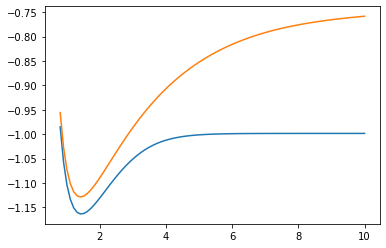

In [9]:
plt.plot(Rvals,Calculated_Energies1,Rvals,Calculated_Energies)

In [ ]:
#%%
#
#  MAKE PLOTS FROM THE OUTPUT FILE OR PUT PLOTTING COMMANDS HERE
#  FOR A PROPERLY LABELED GRAPH 
#  plotting with xmgrace is recommended, and easier than plotting
#  several cases from this python script
#
exit()